**1st strategy for E.coli 5-HTP production**

In [1]:
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd

In [2]:
model = read_sbml_model('../data/iML1515.xml')

**5-HTP synthesis pathway**

5-HTP production (phhA)\
tetrahydromonapterin (MH4) + oxygen + tryptophan (trp) <-> 4a-hydroxytetrahydromonopterin (hydro-MH4) + 5-hydroxytryptophan (5-HTP)

In [3]:
#add metabolites to the system
four_alpha_hydroxytetrahydromonopterin = Metabolite(id='hthpth_c', compartment='c')
hydroxytryptophan = Metabolite(id='htrp_c', compartment='c')

In [4]:
#design reaction
phhA = Reaction('phhA')
phhA.add_metabolites({model.metabolites.thmnp_c: -1,
                      model.metabolites.o2_c: -1,
                      model.metabolites.trp__L_c: -1,
                      four_alpha_hydroxytetrahydromonopterin: 1,
                      hydroxytryptophan: 1
                     })
print(phhA.build_reaction_string())

o2_c + thmnp_c + trp__L_c --> hthpth_c + htrp_c


In [5]:
#add reaction to the system
model.add_reactions([phhA])
model.reactions.phhA

Reaction identifier,phhA
Name,
Memory address,0x07f2e4570e3a0
Stoichiometry,o2_c + thmnp_c + trp__L_c --> hthpth_c + htrp_c O2 O2 + Tetrahydromonapterin + L-Tryptophan --> +
GPR,
Lower bound,0.0
Upper bound,1000.0


**Restioration of MH4**

pterin-4alpha-carbinolamine dehydratase (PCD)\
4a-hydroxytetrahydromonopterin (hydro-MH4) <-> dihydromonapterin (MH2) + water

In [6]:
#design reaction
pcd = Reaction('pcd')
pcd.add_metabolites({four_alpha_hydroxytetrahydromonopterin: -1,
                      model.metabolites.dhmpt_c: 1,
                      model.metabolites.h2o_c: 1,
                     })
print(pcd.build_reaction_string())

hthpth_c --> dhmpt_c + h2o_c


In [7]:
#add reaction to the system
model.add_reactions([pcd])
model.reactions.pcd

Reaction identifier,pcd
Name,
Memory address,0x07f2e457230a0
Stoichiometry,hthpth_c --> dhmpt_c + h2o_c --> Dihydromonapterin + H2O H2O
GPR,
Lower bound,0.0
Upper bound,1000.0


dihydromonapterin reductase (DHMR)\
dihydromonapterin (MH2) + H+ + NADPH <-> NADP+ + tetrahydromonapterin (MH4)

In [8]:
#design reaction
dhmr = Reaction('dhmr')
dhmr.add_metabolites({model.metabolites.h_c: -1,
                      model.metabolites.dhmpt_c: -1,
                      model.metabolites.nadph_c: -1,
                      model.metabolites.nadp_c: 1,
                      model.metabolites.thmnp_c: 1
                     })
print(dhmr.build_reaction_string())

dhmpt_c + h_c + nadph_c --> nadp_c + thmnp_c


**Remove 5-HTP from the system**

In [9]:
five_hydroxytryptophan_exchange = Reaction('EX_htrp')
five_hydroxytryptophan_exchange.add_metabolites({model.metabolites.htrp_c: -1})
model.add_reaction(five_hydroxytryptophan_exchange)

**Optimize model**

In [10]:
print(model.objective)

Maximize
1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685


In [11]:
model.optimize().objective_value

0.8769972144269627

**Checking max 5-HTP production and respective growth rate if objective value is changed to the 5-HTP export reaction**

In [12]:
with model:
    print(model.reactions.phhA)
    model.objective = model.reactions.phhA
    solution = model.optimize()
    max_5HTP_production = solution.objective_value
    print(max_5HTP_production)
    print(solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)

phhA: o2_c + thmnp_c + trp__L_c --> hthpth_c + htrp_c
4.279204339963833
0.0


**Observing how the growth rate changes with increasing 5-HTP export flux**

In [13]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope

In [14]:
ppp_5HTP = production_envelope(model,
                    reactions=[model.reactions.phhA],
                    objective=model.reactions.BIOMASS_Ec_iML1515_core_75p37M)

In [15]:
ppp_5HTP

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,phhA
0,EX_glc__D_e,0.0,0.0,NaN,0.876997,1.161751e+01,NaN,0.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.831248,1.101147e+01,NaN,0.225221
2,EX_glc__D_e,0.0,0.0,NaN,0.785499,1.040543e+01,NaN,0.450443
3,EX_glc__D_e,0.0,0.0,NaN,0.739749,9.799397e+00,NaN,0.675664
4,EX_glc__D_e,0.0,0.0,NaN,0.694000,9.193359e+00,NaN,0.900885
5,EX_glc__D_e,0.0,0.0,NaN,0.647766,8.580901e+00,NaN,1.126106
6,EX_glc__D_e,0.0,0.0,NaN,0.601497,7.967979e+00,NaN,1.351328
7,EX_glc__D_e,0.0,0.0,NaN,0.555228,7.355058e+00,NaN,1.576549
8,EX_glc__D_e,0.0,0.0,NaN,0.508959,6.742136e+00,NaN,1.801770
9,EX_glc__D_e,0.0,0.0,NaN,0.462690,6.129215e+00,NaN,2.026992


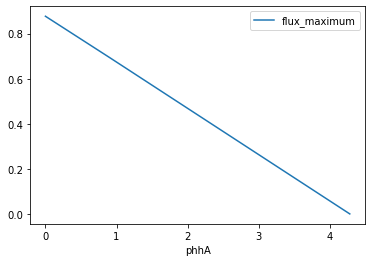

In [16]:
ppp_5HTP.plot(x='phhA', y='flux_maximum')

**Optmizing 5-HTP production and growth rate**

In [17]:
from cobra.flux_analysis import flux_variability_analysis

In [18]:
hydroxy_trp_flux_analysis = flux_variability_analysis(model, model.reactions.phhA, fraction_of_optimum = 0.5)
print(hydroxy_trp_flux_analysis)

      minimum   maximum
phhA      0.0  2.144746


Keeping growth rate at 50%, we get around 50% of maximum 5-HTP flux, which is bigger than in case of B.subtilis, but smaller than 2nd strategy for E.coli

**Knocking out a single gene and setting the objective value of the model for 5-HTP export flux**

Only non-zero biomass production flux knock-outs are selected

In [19]:
for gene in model.genes:
    with model:
        gene.knock_out()
        model.objective = model.reactions.phhA
        solution = model.optimize()
        if solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M > 0:
            print ('5-HTP export flux:', solution.fluxes.tph, 'Gene ID:', gene.id, 'Biomass production:', solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)

No solutions displayed, no single knock-outs and optmization to maximum 5-HTP production yields positive growth rate

**Knocking out a single gene, running optimisation for max biomass production flux and observing 5-HTP export flux**

Only non-zero 5-HTP export flux knock-outs are selected

In [20]:
knock_out_list = pd.DataFrame(columns=['Gene ID', '5-HTP export flux', 'Biomass production flux'])
for gene in model.genes:
    with model:
        gene.knock_out()
        solution = model.optimize()
        if solution.fluxes.phhA > 0:
            knock_out_list = knock_out_list.append({ 'Gene ID': gene.id, '5-HTP export flux': solution.fluxes.phhA, 'Biomass production flux': model.optimize().objective_value}, ignore_index=True)

In [21]:
print(knock_out_list)

Empty DataFrame
Columns: [Gene ID, 5-HTP export flux, Biomass production flux]
Index: []


No solutions, no single knock-outs give rise to positive htp flux with maximum growth rate

**Check whether change of carbon source will influence the growth rate at maximum 5-HTP flux**

In [22]:
#create list to store the reactions' IDs
carbon_uptake = list()

#go through all metabolites in the model that have carbon in their chem.structure
for metabolite in model.metabolites:
    if 'C' in metabolite.elements:
        #find metabolites that are external
        if metabolite.id[-1] == 'e':
            reactions = metabolite.reactions
            #pick reactions which exchange the metabolite with the external environment
            for element in reactions:
                if str(element.id[:2]) == 'EX':
                    carbon_uptake.append(element.id)

In [23]:
medium = model.medium

with model:
    #replace glucose with each exchange reaction from the possible carbon source reactions
    for reaction in carbon_uptake:
        medium['EX_glc__D_e'] = 0
        medium[reaction] = 10
        model.medium = medium
        model.objective = model.reactions.phhA
        solution = model.optimize()
        max_5HTP_production = solution.objective_value
        if solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M > 0:
            print(solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)
            print(max_5HTP_production)

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


No solutions, changing of medium does not influence the increase of growth rate at 5-HTP maximum flux production

In [24]:
# writing the model
write_sbml_model(model, "../data/iML1515_5htp_1st_strategy.xml")

**Changing the boundaries for chorismate conversion to prephenate**

The idea behind this part is to restrict and control the flow of chorismate, a precursor of L-tryptophane and 5-HTP, to other aromatic amino acid production. For this we are setting bounds for a CHORM reaction (chorismate --> prephenate), where we are changing the lower bound to be above 0, so that some chorismate is routed for other essential amino acids in the biomass reaction to ensure growth, and the higher bound ensures we are not depleting the precursor pool for 5-HTP.

In [25]:
for metabolite in model.metabolites.query('Chorismate', 'name'):
    print(metabolite.name, metabolite.id)

Chorismate chor_c


In [26]:
for reaction in model.metabolites.chor_c.reactions:
    print(reaction)

BIOMASS_Ec_iML1515_WT_75p37M: 0.000223 10fthf_c + 0.000223 2dmmql8_c + 2.5e-05 2fe2s_c + 0.000248 4fe4s_c + 0.000223 5mthf_c + 0.000279 accoa_c + 0.000223 adocbl_c + 0.499149 ala__L_c + 0.000223 amet_c + 0.28742 arg__L_c + 0.234232 asn__L_c + 0.234232 asp__L_c + 75.55223 atp_c + 2e-06 btn_c + 0.004952 ca2_c + 0.000223 chor_c + 0.004952 cl_c + 0.002944 clpn160_p + 0.00229 clpn161_p + 0.00118 clpn181_p + 0.000168 coa_c + 2.4e-05 cobalt2_c + 0.008151 colipa_e + 0.129799 ctp_c + 0.000674 cu2_c + 0.088988 cys__L_c + 0.024805 datp_c + 0.025612 dctp_c + 0.025612 dgtp_c + 0.024805 dttp_c + 0.000223 enter_c + 0.000223 fad_c + 0.006388 fe2_c + 0.007428 fe3_c + 0.255712 gln__L_c + 0.255712 glu__L_c + 0.595297 gly_c + 0.154187 glycogen_c + 0.000223 gthrd_c + 0.209121 gtp_c + 70.028756 h2o_c + 0.000223 hemeO_c + 0.092056 his__L_c + 0.282306 ile__L_c + 0.18569 k_c + 0.437778 leu__L_c + 3e-06 lipopb_c + 0.333448 lys__L_c + 3.1e-05 malcoa_c + 0.149336 met__L_c + 0.008253 mg2_c + 0.000223 mlthf_c + 0.0

In [47]:
#here we do not change the bounds for chorismate conversion. The objective vaue is set up for 5-HTP production.
with model:
    model.reactions.phhA.bounds = 0, 1 #setting the upper bound for the phhA to allow some growth while producing 5-HTP
    model.objective = model.reactions.phhA #setting objective for 5-HTP production
    solution = model.optimize()
    print('Max 5-HTP:', solution.objective_value)
    print('Growth:', solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)
    print('CHORM:', solution.fluxes.CHORM)

Max 5-HTP: 1.0
Growth: 0.13552972023587273
CHORM: 0.04382814304875747


In [48]:
#here we try to keep chorismate conversion below the value in the above example to see the effect on the the 5-HTP and biomass production.
#Chorismate is a precursor for L-tryptohan and other aromatic amino acids used in the biomass equation.
#The objective value is 5-HTP production.
with model:
    model.reactions.CHORM.bounds = 0.001, 0.04 #setting tighter bounds for conversion of chorismate to prephenate to make sure the cell still grows while producing 5-HTP
    model.reactions.phhA.bounds = 0, 1 #setting the upper bound for the phhA to allow some growth while producing 5-HTP
    model.objective = model.reactions.phhA #setting objective for 5-HTP production
    solution = model.optimize()
    print('Max 5-HTP:', solution.objective_value)
    print('Growth:', solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)
    print('CHORM:', solution.fluxes.CHORM)

Max 5-HTP: 1.0
Growth: 0.12369195754892029
CHORM: 0.04


Upon limiting max CHORM flux, the growth was impaired. Let's now see what will happen if the CHORM reaction is limited while biomass production is set as an objective value.

In [49]:
#here we do not change the bounds for chorismate conversion. The objective vaue is set up for biomass production.
with model:
    model.reactions.phhA.bounds = 1, 1000 
    solution = model.optimize()
    print('Max 5-HTP:', solution.fluxes.phhA)
    print('Growth:', solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)
    print('CHORM:', solution.fluxes.CHORM)

Max 5-HTP: 1.0
Growth: 0.6736729353453018
CHORM: 0.21785504852370507


In [50]:
#here we try to keep chorismate conversion below the value in the above example to see the effect on the the 5-HTP and biomass production.
#Chorismate is a precursor for L-tryptohan and other aromatic amino acids used in the biomass equation.
#The objective value is biomass production.
with model:
    model.reactions.phhA.bounds = 1, 1000 #keeping the lower bound for 5-HTP production above 0 so that the cell does not ditch the reaction
    model.reactions.CHORM.bounds = 0.001, 0.2
    solution = model.optimize()
    print('Max 5-HTP:', solution.fluxes.phhA)
    print('Growth:', solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)
    print('CHORM:', solution.fluxes.CHORM)

Max 5-HTP: 1.0
Growth: 0.6184597877446011
CHORM: 0.2


When biomass is selected as an objective value and 5-HTP flux is forsed to be at least 1, biomass production is still impaired when CHORM reaction is limited. The 5-HTP flux at the same time does not get above the lower bound, thus it can be concluded that redirecting the flux of chorismate from phenylalanine and tyrosine production towards the tryptophan production does not increase the yield of 5-HTP.